<a href="https://colab.research.google.com/github/haris-lutafullah/Research-Work/blob/main/Traffic_Prediction_System_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Importing Library Files**</p>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Pre-Processing**</p>

Correlation Matrix:
                      holiday      temp   rain_1h   snow_1h  clouds_all  \
holiday              1.000000  0.004646  0.000177  0.000863    0.007506   
temp                 0.004646  1.000000  0.009069 -0.019755   -0.101976   
rain_1h              0.000177  0.009069  1.000000 -0.000090    0.004818   
snow_1h              0.000863 -0.019755 -0.000090  1.000000    0.027931   
clouds_all           0.007506 -0.101976  0.004818  0.027931    1.000000   
weather_main        -0.001831 -0.033441  0.009535  0.036637    0.500745   
weather_description  0.000485 -0.049434  0.010774  0.005101   -0.341891   
traffic_volume       0.038057  0.130299  0.004714  0.000733    0.067054   

                     weather_main  weather_description  traffic_volume  
holiday                 -0.001831             0.000485        0.038057  
temp                    -0.033441            -0.049434        0.130299  
rain_1h                  0.009535             0.010774        0.004714  
snow_1h     

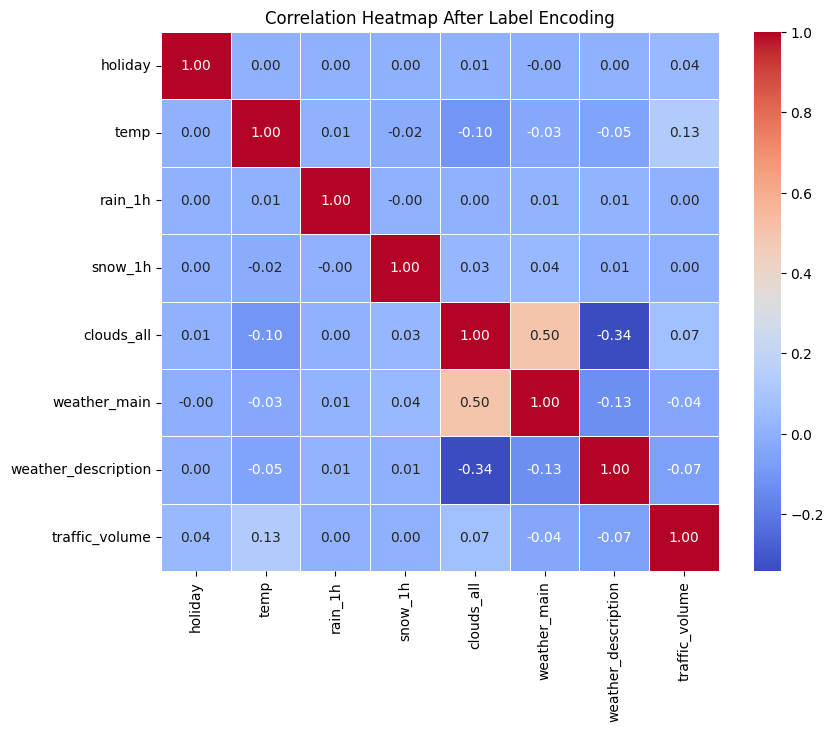

In [ ]:

df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
df['date_time'] = pd.to_datetime(df['date_time'])
df.set_index('date_time', inplace=True)

# Label Encoding
label_encoders = {}
categorical_cols = ['holiday', 'weather_main', 'weather_description']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Handle outliers using IQR
Q1 = df['traffic_volume'].quantile(0.25)
Q3 = df['traffic_volume'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['traffic_volume'] >= lower_bound) & (df['traffic_volume'] <= upper_bound)]


# Compute correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap After Label Encoding")
plt.show()

# Create lag features
for lag in range(1, 4):  # 3 lag features
    df[f'lag_{lag}'] = df['traffic_volume'].shift(lag)
df.dropna(inplace=True)

# Normalize features
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df)
traffic_scaler = MinMaxScaler()
df['traffic_volume'] = traffic_scaler.fit_transform(df[['traffic_volume']])

# Train-test split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]
X_train, y_train = train.drop(columns=['traffic_volume']), train['traffic_volume']
X_test, y_test = test.drop(columns=['traffic_volume']), test['traffic_volume']

# Convert to PyTorch tensors
X_train_torch, y_train_torch = torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32)
X_test_torch, y_test_torch = torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32)


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**LSTM Model Implementation and Training**</p>

In [ ]:
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# LSTM Predictions
y_pred_lstm = lstm_model.predict(X_test)
y_pred_lstm = traffic_scaler.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()
y_test_inv = traffic_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 0.0738 - val_loss: 0.0250
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.0319 - val_loss: 0.0154
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 0.0194 - val_loss: 0.0095
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.0139 - val_loss: 0.0072
Epoch 5/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.0115 - val_loss: 0.0064
Epoch 6/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 0.0107 - val_loss: 0.0056
Epoch 7/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - loss: 0.0102 - val_loss: 0.0053
Epoch 8/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.0095 - val_loss: 0.0064
Epoch 9/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.0095 - val_loss: 0.0055
Epoch 10/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0090 - val_loss: 0.0051
Epoch 11/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0086 - val_loss: 0.0051
Epoch 12/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**ARIMA Model Implementation and Training**</p>

In [ ]:

train_arima, test_arima = df['traffic_volume'][:train_size], df['traffic_volume'][train_size:]
model_arima = ARIMA(train_arima, order=(5, 1, 0))
model_arima_fit = model_arima.fit()
y_pred_arima = model_arima_fit.forecast(steps=len(test_arima))
y_pred_arima = y_pred_arima[:len(y_test_inv)]


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**TSMixer Model Implementation and Training**</p>

In [ ]:

class TSMixer(nn.Module):
    def __init__(self, input_dim):
        super(TSMixer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        return self.fc4(x)

# Initialize and Train TSMixer Model
tsmixer_model = TSMixer(X_train_torch.shape[1])
criterion = nn.MSELoss()
optimizer = optim.AdamW(tsmixer_model.parameters(), lr=0.0003, weight_decay=1e-4)

for epoch in range(500):
    tsmixer_model.train()
    optimizer.zero_grad()
    outputs = tsmixer_model(X_train_torch).squeeze()
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()

# TSMixer Predictions
y_pred_tsmixer = tsmixer_model(X_test_torch).detach().numpy().flatten()
y_pred_tsmixer = traffic_scaler.inverse_transform(y_pred_tsmixer.reshape(-1, 1)).flatten()


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Hybrid LSTM and TSMixer Model Implementation and Training**</p>

In [ ]:
# ========================
# 1 DEFINE LSTM MODEL
# ========================
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x, _ = self.lstm(x.unsqueeze(1))  # Add batch dimension
        x = self.fc(x[:, -1, :])
        return x

lstm_model = LSTMModel(X_train.shape[1])

In [ ]:
# ========================
# 2 DEFINE TSMixer MODEL
# ========================
class TSMixer(nn.Module):
    def __init__(self, input_dim):
        super(TSMixer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        return self.fc4(x)

tsmixer_model = TSMixer(X_train.shape[1])
# ========================
# 3 HYBRID MODEL (LSTM + TSMixer)
# ========================
class HybridModel(nn.Module):
    def __init__(self, input_dim):
        super(HybridModel, self).__init__()
        self.lstm = LSTMModel(input_dim)
        self.tsmixer = TSMixer(input_dim)
        self.fc = nn.Linear(2, 1)  # Combine both outputs

    def forward(self, x):
        lstm_out = self.lstm(x)
        tsmixer_out = self.tsmixer(x)
        combined = torch.cat((lstm_out, tsmixer_out), dim=1)
        return self.fc(combined)

hybrid_model = HybridModel(X_train.shape[1])
# ========================
# 4 TRAINING
# ========================
criterion = nn.MSELoss()
optimizer = optim.AdamW(hybrid_model.parameters(), lr=0.0001, weight_decay=1e-4)

batch_size = 64
num_epochs = 500

train_dataset = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    hybrid_model.train()
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = hybrid_model(batch_X).squeeze()
        loss = criterion(outputs, batch_y.squeeze())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")


Epoch [10/500], Loss: 0.0096
Epoch [20/500], Loss: 0.0082
Epoch [30/500], Loss: 0.0076
Epoch [40/500], Loss: 0.0073
Epoch [50/500], Loss: 0.0070
Epoch [60/500], Loss: 0.0069
Epoch [70/500], Loss: 0.0068
Epoch [80/500], Loss: 0.0066
Epoch [90/500], Loss: 0.0065
Epoch [100/500], Loss: 0.0065
Epoch [110/500], Loss: 0.0064
Epoch [120/500], Loss: 0.0064
Epoch [130/500], Loss: 0.0063
Epoch [140/500], Loss: 0.0062
Epoch [150/500], Loss: 0.0062
Epoch [160/500], Loss: 0.0062
Epoch [170/500], Loss: 0.0062
Epoch [180/500], Loss: 0.0061
Epoch [190/500], Loss: 0.0061
Epoch [200/500], Loss: 0.0061
Epoch [210/500], Loss: 0.0061
Epoch [220/500], Loss: 0.0061
Epoch [230/500], Loss: 0.0060
Epoch [240/500], Loss: 0.0060
Epoch [250/500], Loss: 0.0060
Epoch [260/500], Loss: 0.0060
Epoch [270/500], Loss: 0.0059
Epoch [280/500], Loss: 0.0060
Epoch [290/500], Loss: 0.0059
Epoch [300/500], Loss: 0.0059
Epoch [310/500], Loss: 0.0059
Epoch [320/500], Loss: 0.0059
Epoch [330/500], Loss: 0.0059
Epoch [340/500], Lo

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**hybrid KNN LSTM Implementation and Training**</p>

In [ ]:
# ========================
#  KNN MODEL FOR FEATURE SELECTION
# ========================
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
X_train_knn = knn.predict(X_train).reshape(-1, 1)
X_test_knn = knn.predict(X_test).reshape(-1, 1)

# ========================
#  KNN-LSTM MODEL
# ========================
def build_knn_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Reshape for LSTM
X_train_knn_lstm = np.reshape(X_train_knn, (X_train_knn.shape[0], 1, 1))
X_test_knn_lstm = np.reshape(X_test_knn, (X_test_knn.shape[0], 1, 1))

knn_lstm_model = build_knn_lstm_model((1, 1))
knn_lstm_model.fit(X_train_knn_lstm, y_train, epochs=10, batch_size=32, verbose=1)
y_pred_knn_lstm = knn_lstm_model.predict(X_test_knn_lstm)

# Rescale predictions back to original scale
y_pred_knn_lstm = traffic_scaler.inverse_transform(y_pred_knn_lstm)
y_test_rescaled = traffic_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0535
Epoch 2/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0083
Epoch 3/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0074
Epoch 4/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0070
Epoch 5/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0068
Epoch 6/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0068
Epoch 7/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0067
Epoch 8/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0066
Epoch 9/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0065
Epoch 10/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0066
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**DASNet Model Implementation and Training**</p>

In [ ]:
# ========================
#  IMPLEMENT DASNet
# ========================
class DASNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(DASNet, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        out = self.fc(context)
        return out.squeeze()

# Model setup
input_dim = X_train_torch.shape[1]
dasnet = DASNet(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(dasnet.parameters(), lr=0.001)

# Prepare data for training
train_dataset = TensorDataset(X_train_torch.unsqueeze(1), y_train_torch)
test_dataset = TensorDataset(X_test_torch.unsqueeze(1), y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Training loop
epochs = 20
for epoch in range(epochs):
    dasnet.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = dasnet(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}')

# ========================
#  EVALUATION (UPDATED)
# ========================
dasnet.eval()
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = dasnet(X_batch)
        y_pred_list.append(y_pred.numpy())
        y_true_list.append(y_batch.numpy())

y_pred_list = np.concatenate(y_pred_list)
y_true_list = np.concatenate(y_true_list)

# Convert back to original scale
y_pred_actual_Dasnet = traffic_scaler.inverse_transform(y_pred_list.reshape(-1, 1))
y_true_actual = traffic_scaler.inverse_transform(y_true_list.reshape(-1, 1))

Epoch 1/20, Loss: 0.0252
Epoch 2/20, Loss: 0.0095
Epoch 3/20, Loss: 0.0090
Epoch 4/20, Loss: 0.0087
Epoch 5/20, Loss: 0.0086
Epoch 6/20, Loss: 0.0085
Epoch 7/20, Loss: 0.0082
Epoch 8/20, Loss: 0.0080
Epoch 9/20, Loss: 0.0079
Epoch 10/20, Loss: 0.0078
Epoch 11/20, Loss: 0.0076
Epoch 12/20, Loss: 0.0075
Epoch 13/20, Loss: 0.0075
Epoch 14/20, Loss: 0.0074
Epoch 15/20, Loss: 0.0073
Epoch 16/20, Loss: 0.0073
Epoch 17/20, Loss: 0.0072
Epoch 18/20, Loss: 0.0071
Epoch 19/20, Loss: 0.0071
Epoch 20/20, Loss: 0.0070


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**DASNet LSTM Model Implementation and Training**</p>

In [ ]:
# Define GCN Layer
class GCNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCNLayer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x, adj):
        x = torch.matmul(adj, x.T).T  # Fix dimension mismatch
        return torch.relu(self.fc(x))

# Define DASNet-LSTM Model
class DASNetLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_units, adj_matrix):
        super(DASNetLSTM, self).__init__()
        self.adj = torch.tensor(adj_matrix, dtype=torch.float32)
        self.gcn = GCNLayer(input_dim, hidden_dim)
        self.attn = nn.Linear(hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, lstm_units, batch_first=True)
        self.fc = nn.Linear(lstm_units, 1)

    def forward(self, x):
        x = self.gcn(x, self.adj)
        attn_weights = torch.softmax(self.attn(x), dim=1)
        x = x * attn_weights  # Apply attention
        x = x.unsqueeze(1)  # LSTM expects (batch, seq_len, features)
        x, _ = self.lstm(x)
        return self.fc(x[:, -1, :])  # Final output

# Adjacency matrix (Identity as placeholder)
adj_matrix = np.eye(X_train.shape[1])


In [ ]:
model = DASNetLSTM(input_dim=X_train.shape[1], hidden_dim=64, lstm_units=32, adj_matrix=adj_matrix)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
# Training loop
num_epochs = 600

# Convert X_train to a PyTorch tensor before feeding it into the model
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)  # Also convert y_train for consistency

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor).squeeze() # Pass the tensor here
    loss = criterion(outputs, y_train_tensor) # Pass the tensor here
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/600], Loss: 0.2083
Epoch [20/600], Loss: 0.1840
Epoch [30/600], Loss: 0.1596
Epoch [40/600], Loss: 0.1343
Epoch [50/600], Loss: 0.1085
Epoch [60/600], Loss: 0.0861
Epoch [70/600], Loss: 0.0719
Epoch [80/600], Loss: 0.0667
Epoch [90/600], Loss: 0.0645
Epoch [100/600], Loss: 0.0612
Epoch [110/600], Loss: 0.0576
Epoch [120/600], Loss: 0.0537
Epoch [130/600], Loss: 0.0490
Epoch [140/600], Loss: 0.0433
Epoch [150/600], Loss: 0.0372
Epoch [160/600], Loss: 0.0325
Epoch [170/600], Loss: 0.0293
Epoch [180/600], Loss: 0.0268
Epoch [190/600], Loss: 0.0247
Epoch [200/600], Loss: 0.0227
Epoch [210/600], Loss: 0.0203
Epoch [220/600], Loss: 0.0175
Epoch [230/600], Loss: 0.0149
Epoch [240/600], Loss: 0.0127
Epoch [250/600], Loss: 0.0111
Epoch [260/600], Loss: 0.0106
Epoch [270/600], Loss: 0.0105
Epoch [280/600], Loss: 0.0103
Epoch [290/600], Loss: 0.0102
Epoch [300/600], Loss: 0.0101
Epoch [310/600], Loss: 0.0100
Epoch [320/600], Loss: 0.0099
Epoch [330/600], Loss: 0.0098
Epoch [340/600], Lo

In [ ]:
# Evaluate model
model.eval()
# Convert X_test to a PyTorch tensor before feeding it into the model
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32) # Convert X_test to Tensor
y_pred_Dasnet_LSTM = model(X_test_tensor).detach().numpy() # Pass the tensor to the model


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Evaluations of the models**</p>

In [ ]:
# ========================
# 6⃣ MODEL EVALUATION
# ========================
hybrid_model.eval()
with torch.no_grad():
    y_test_pred = hybrid_model(X_test_torch).squeeze().numpy()

# Inverse transform predictions
y_test_pred_inv = traffic_scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
y_test_actual_inv = traffic_scaler.inverse_transform(y_test_torch.numpy().reshape(-1, 1)).flatten()

# Metrics calculation
def mean_absolute_percentage_error(y_true, y_pred):
    non_zero_indices = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return round(mse, 3), round(rmse, 3), round(mae, 3), round(mape, 3), round(r2, 3)

# Evaluate models
metrics_hybrid = evaluate_model(y_test_actual_inv, y_test_pred_inv)
metrics_lstm = evaluate_model(y_test_actual_inv, y_pred_lstm)
metrics_arima = evaluate_model(y_test_actual_inv, y_pred_arima)
metrics_tsmixer = evaluate_model(y_test_actual_inv, y_pred_tsmixer)
metrics_knn_lstm = evaluate_model(y_test_actual_inv, y_pred_knn_lstm)
metrics_dasnet = evaluate_model(y_test_actual_inv, y_pred_actual_Dasnet)
metrics_dasnet_lstm=evaluate_model(y_test_actual_inv,y_pred_Dasnet_LSTM)


# PrettyTable for Model Comparison
table = PrettyTable()
table.field_names = ["Model", "MSE", "RMSE", "MAE", "MAPE", "R²"]
table.add_row(["LSTM", *metrics_lstm])
table.add_row(["ARIMA", *metrics_arima])
table.add_row(["TSMixer", *metrics_tsmixer])
table.add_row(["Hybrid LSTM-TSMixer", *metrics_hybrid])
table.add_row(["KNN-LSTM", *metrics_knn_lstm])
table.add_row(["DasNet",*metrics_dasnet])
table.add_row(["Hybrid DasNet LSTM",*metrics_dasnet_lstm])

print(table)


+---------------------+-------+-------+-------+---------+--------+
|        Model        |  MSE  |  RMSE |  MAE  |   MAPE  |   R²   |
+---------------------+-------+-------+-------+---------+--------+
|         LSTM        | 0.004 | 0.062 | 0.042 |  15.382 | 0.948  |
|        ARIMA        |  0.08 | 0.283 | 0.248 | 141.505 | -0.097 |
|       TSMixer       | 0.008 | 0.089 | 0.067 |  30.223 | 0.891  |
| Hybrid LSTM-TSMixer | 0.003 | 0.057 | 0.038 |  13.277 | 0.956  |
|       KNN-LSTM      | 0.004 | 0.066 | 0.045 | 190.739 | 0.941  |
|        DasNet       | 0.004 | 0.066 | 0.046 | 186.672 | 0.941  |
|  Hybrid DasNet LSTM | 0.006 | 0.076 | 0.055 | 187.552 | 0.922  |
+---------------------+-------+-------+-------+---------+--------+


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Plotting**</p>

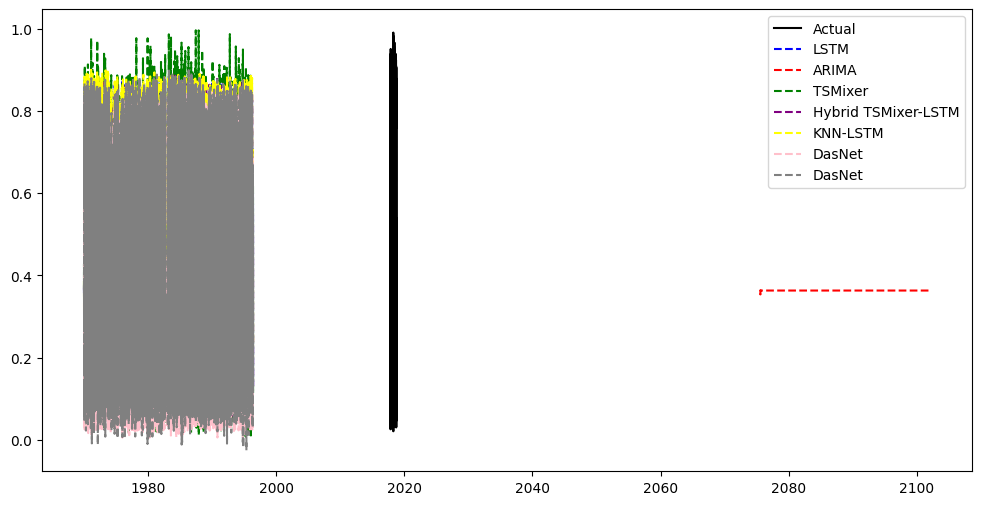

In [ ]:
# ========================
# 6️⃣ PLOT MODEL PREDICTIONS
# ========================
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual", color='black')
plt.plot(y_pred_lstm, label="LSTM", linestyle='dashed', color='blue')
plt.plot(y_pred_arima, label="ARIMA", linestyle='dashed', color='red')
plt.plot(y_pred_tsmixer, label="TSMixer", linestyle='dashed', color='green')
plt.plot( y_test_pred, label="Hybrid TSMixer-LSTM", linestyle='dashed', color='purple')
plt.plot(y_pred_knn_lstm, label="KNN-LSTM", linestyle='dashed', color='yellow')
plt.plot(y_pred_actual_Dasnet, label="DasNet", linestyle='dashed', color='pink')
plt.plot(y_pred_Dasnet_LSTM, label="DasNet", linestyle='dashed', color='grey')
plt.legend()
plt.show()



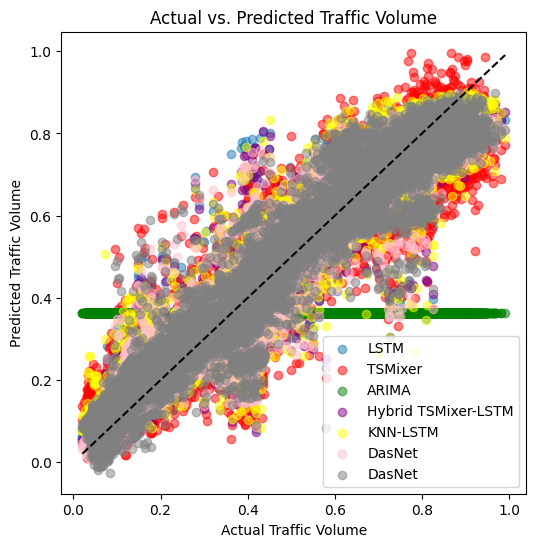

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lstm, alpha=0.5, label="LSTM")
plt.scatter(y_test, y_pred_tsmixer, alpha=0.5, label="TSMixer", color='red')
plt.scatter(y_test, y_pred_arima, alpha=0.5, label="ARIMA", color='green')
plt.scatter(y_test, y_test_pred, alpha=0.5, label="Hybrid TSMixer-LSTM", color='purple')
plt.scatter(y_test, y_pred_knn_lstm, alpha=0.5, label="KNN-LSTM", color='yellow')
plt.scatter(y_test, y_pred_actual_Dasnet, alpha=0.5, label="DasNet", color='pink')
plt.scatter(y_test, y_pred_Dasnet_LSTM, alpha=0.5, label="DasNet", color='grey')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()


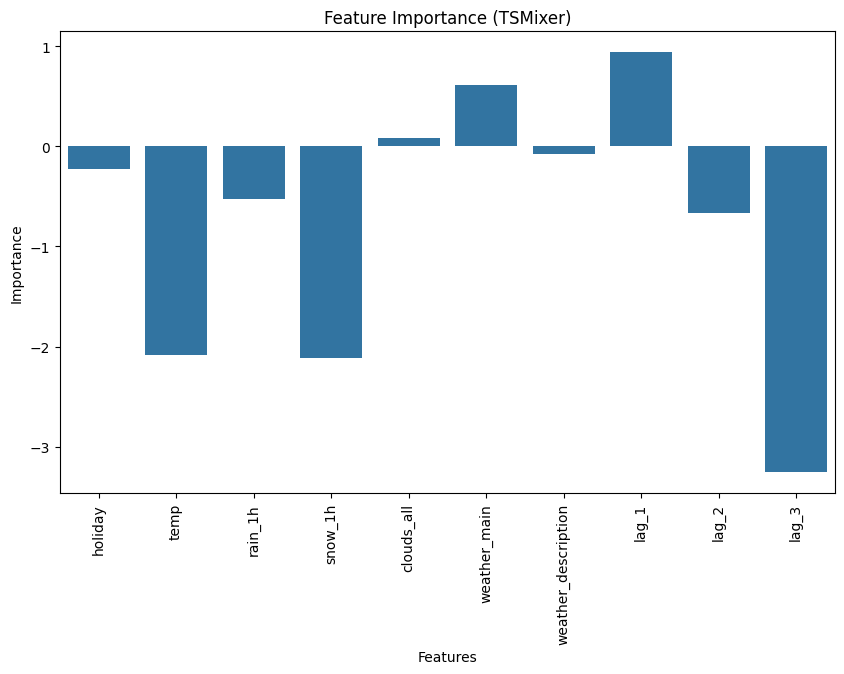

In [ ]:
import seaborn as sns
importance = tsmixer_model.fc1.weight.detach().numpy().sum(axis=0)  # Example for TSMixer
plt.figure(figsize=(10, 6))
sns.barplot(x=X_train.columns, y=importance)
plt.xticks(rotation=90)
plt.title("Feature Importance (TSMixer)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

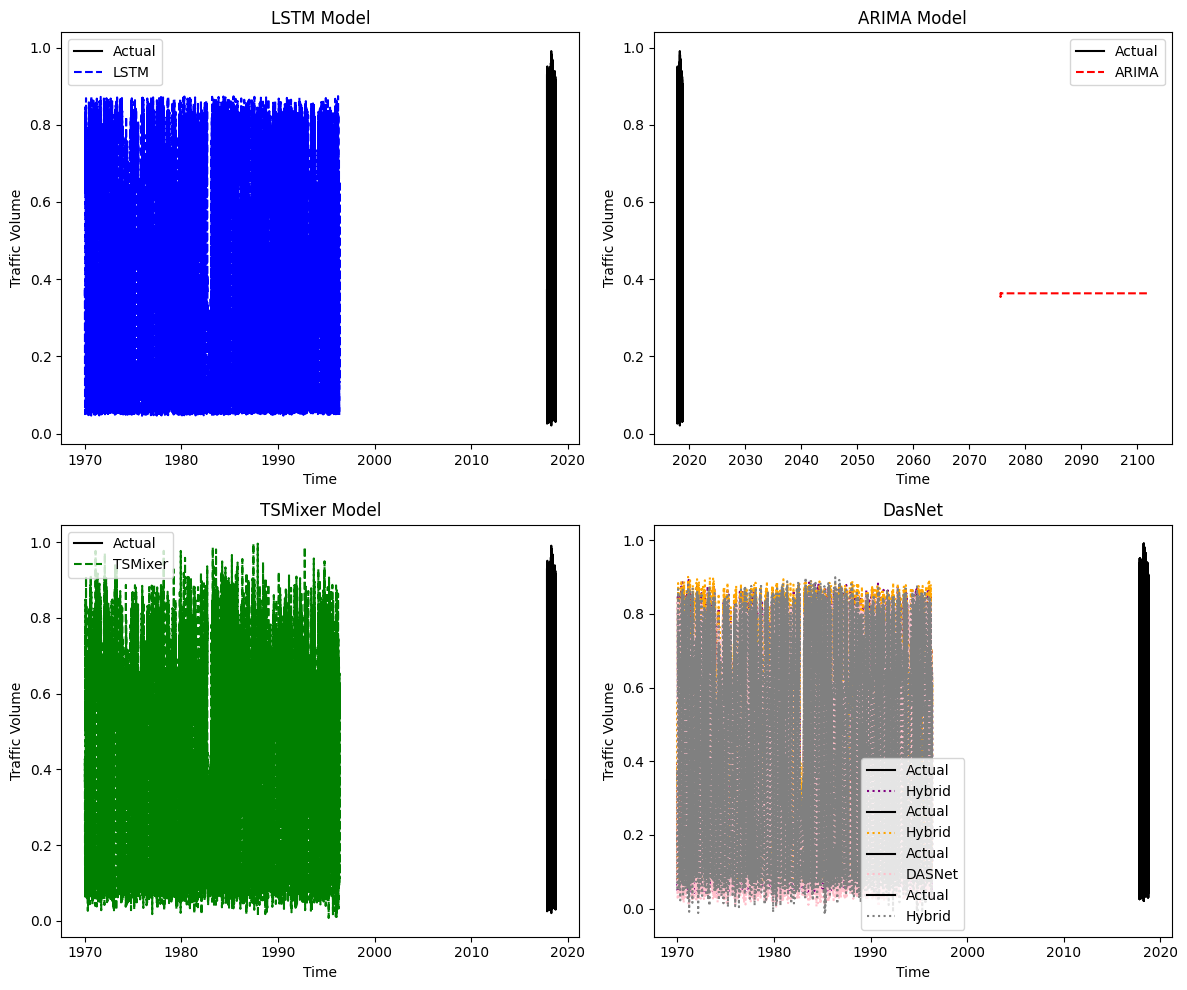

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(y_test, label="Actual", color='black')
axes[0, 0].plot(y_pred_lstm, label="LSTM", linestyle='dashed', color='blue')
axes[0, 0].set_title("LSTM Model")

axes[0, 1].plot(y_test, label="Actual", color='black')
axes[0, 1].plot(y_pred_arima, label="ARIMA", linestyle='dashed', color='red')
axes[0, 1].set_title("ARIMA Model")

axes[1, 0].plot(y_test, label="Actual", color='black')
axes[1, 0].plot(y_pred_tsmixer, label="TSMixer", linestyle='dashed', color='green')
axes[1, 0].set_title("TSMixer Model")

axes[1, 1].plot(y_test, label="Actual", color='black')
axes[1, 1].plot(y_test_pred, label="Hybrid", linestyle='dotted', color='purple')
axes[1, 1].set_title("Hybrid TSMixer-LSTM")

axes[1, 1].plot(y_test, label="Actual", color='black')
axes[1, 1].plot(y_pred_knn_lstm, label="Hybrid", linestyle='dotted', color='orange')
axes[1, 1].set_title("KNN LTM")

axes[1, 1].plot(y_test, label="Actual", color='black')
axes[1, 1].plot(y_pred_actual_Dasnet, label="DASNet", linestyle='dotted', color='pink')
axes[1, 1].set_title("DasNet")


axes[1, 1].plot(y_test, label="Actual", color='black')
axes[1, 1].plot(y_pred_Dasnet_LSTM, label="Hybrid", linestyle='dotted', color='grey')
axes[1, 1].set_title("DasNet")



for ax in axes.flat:
    ax.legend()
    ax.set_xlabel("Time")
    ax.set_ylabel("Traffic Volume")

plt.tight_layout()
plt.show()


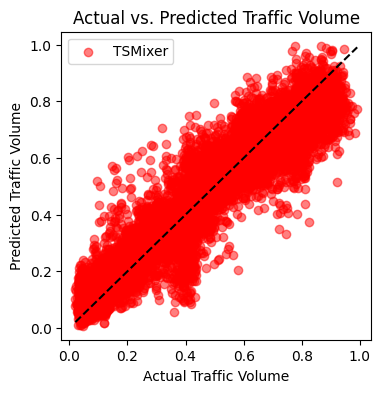

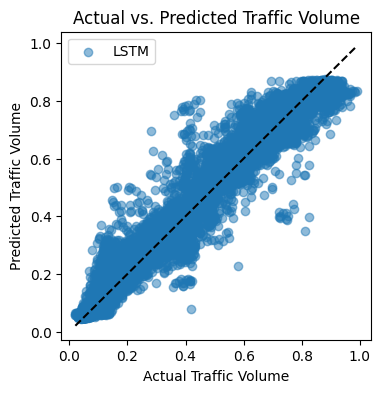

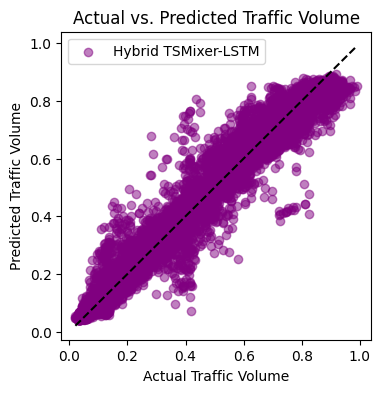

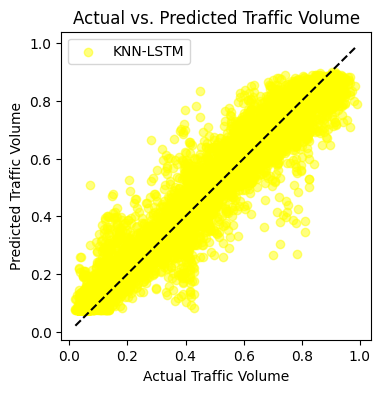

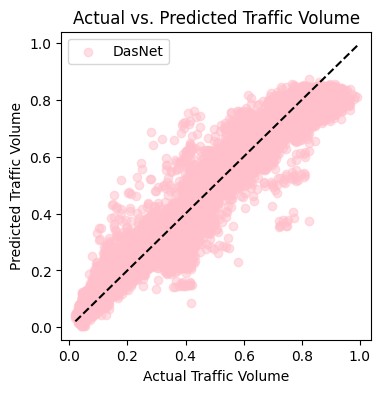

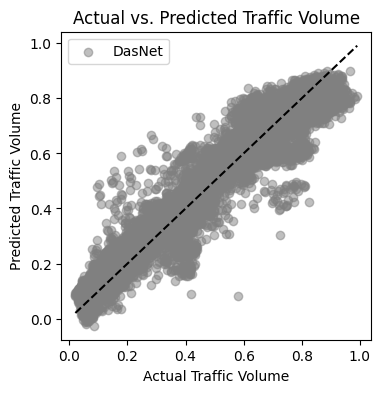

In [ ]:
plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_tsmixer, alpha=0.5, label="TSMixer", color='red')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_lstm, alpha=0.5, label="LSTM")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_test_pred, alpha=0.5, label="Hybrid TSMixer-LSTM", color='purple')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_knn_lstm, alpha=0.5, label="KNN-LSTM", color='yellow')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_actual_Dasnet, alpha=0.5, label="DasNet", color='pink')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_Dasnet_LSTM, alpha=0.5, label="DasNet", color='grey')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()
